In [ ]:
!pip install "pandas<2.0.0"
!pip install scikit-learn==1.3.1
!pip install linearmodels

In [2]:
import numpy as np
import pandas as pd
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)

In [3]:
from google.colab import drive
pd.set_option('display.float_format', lambda x: '%.3f' % x)
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
mroz = pd.read_stata('/content/drive/MyDrive/econometrics/zip/mroz.dta')

In [10]:
mroz = mroz[0:427]

In [11]:
mroz.describe().T

,count,mean,std,min,25%,50%,75%,max
inlf,427.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
hours,427.000,1304.834,776.184,12.000,620.000,1376.000,1911.000,4950.000
kidslt6,427.000,0.141,0.392,0.000,0.000,0.000,0.000,2.000
kidsge6,427.000,1.351,1.317,0.000,0.000,1.000,2.000,8.000
age,427.000,42.000,7.708,30.000,35.000,42.000,47.500,60.000
educ,427.000,12.660,2.288,5.000,12.000,12.000,14.000,17.000
wage,427.000,4.178,3.314,0.128,2.258,3.472,4.973,25.000
repwage,427.000,3.188,2.442,0.000,1.400,3.210,4.550,9.980
hushrs,427.000,2233.005,583.515,175.000,1920.000,2106.000,2504.000,5010.000
husage,427.000,44.637,7.939,30.000,38.000,45.000,51.000,60.000


In [12]:
mroz['log_wage'] = np.log(mroz['wage'])

In [13]:
# Labor Supply Equation
# Endogenous: log_wage
# Instruments: exper, expersq (excluded instruments)
# Exogenous: educ, age, kidslt6, nwifeinc (included instruments)

In [14]:
# Prepare data for labor supply equation
dep_var = mroz['hours']
endog = mroz['log_wage']
exog = sm.add_constant(mroz[['educ', 'age', 'kidslt6', 'nwifeinc']])
instruments = mroz[['exper', 'expersq']]

In [15]:
# Combine exogenous variables and instruments
all_exog = pd.concat([exog, instruments], axis=1)

In [16]:
# Estimate labor supply equation using IV2SLS
labor_supply_model = IV2SLS(dependent=dep_var,
                          exog=exog,
                          endog=endog,
                          instruments=instruments)

labor_supply_results = labor_supply_model.fit(cov_type='robust')

In [17]:
print("Labor Supply Equation Results:")
print(labor_supply_results.summary)

Labor Supply Equation Results:
                          IV-2SLS Estimation Summary                          
Dep. Variable:                  hours   R-squared:                     -1.9930
Estimator:                    IV-2SLS   Adj. R-squared:                -2.0285
No. Observations:                 427   F-statistic:                    12.603
Date:                Sat, Dec 07 2024   P-value (F-stat)                0.0274
Time:                        15:00:38   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2267.6     606.21     3.7407     0.0002      1079.5      3455.8
educ          -183.50

In [18]:
# Calculate labor supply elasticity
mean_hours = mroz['hours'].mean()
wage_coef = labor_supply_results.params['log_wage']
elasticity = wage_coef / mean_hours

In [19]:
print(f"\nLabor Supply Elasticity at mean hours ({mean_hours:.2f}): {elasticity:.4f}")


Labor Supply Elasticity at mean hours (1304.83): 1.2521


In [ ]:
# Wage Offer Equation
# Endogenous: hours
# Instruments: age, kidslt6, nwifeinc (excluded instruments)
# Exogenous: educ, exper, expersq (included instruments)

In [20]:
# Prepare data for wage offer equation
dep_var_wage = mroz['log_wage']
endog_wage = mroz['hours']
exog_wage = sm.add_constant(mroz[['educ', 'exper', 'expersq']])
instruments_wage = mroz[['age', 'kidslt6', 'nwifeinc']]

In [21]:
# Estimate wage offer equation using IV2SLS
wage_offer_model = IV2SLS(dependent=dep_var_wage,
                         exog=exog_wage,
                         endog=endog_wage,
                         instruments=instruments_wage)
wage_offer_results = wage_offer_model.fit(cov_type='robust')

In [22]:
print("\nWage Offer Equation Results:")
print(wage_offer_results.summary)


Wage Offer Equation Results:
                          IV-2SLS Estimation Summary                          
Dep. Variable:               log_wage   R-squared:                      0.1316
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1234
No. Observations:                 427   F-statistic:                    83.924
Date:                Sat, Dec 07 2024   P-value (F-stat)                0.0000
Time:                        15:00:55   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.6449     0.4040    -1.5962     0.1105     -1.4368      0.1470
educ           0.1101 

In [23]:
# First Stage F-statistic for instrument relevance
from linearmodels.iv.model import _OLS
first_stage = _OLS(endog, all_exog).fit()
f_stat = first_stage.f_statistic.stat

In [24]:
print("\nFirst Stage F-statistic:", f_stat)


First Stage F-statistic: 90.19451876421279


In [25]:
# Create results summary DataFrame
results_summary = pd.DataFrame({
    'Labor Supply Equation': pd.Series(labor_supply_results.params),
    'Standard Errors': pd.Series(labor_supply_results.std_errors),
    't-statistics': pd.Series(labor_supply_results.tstats),
    'P-values': pd.Series(labor_supply_results.pvalues)
})

In [26]:
print("\nDetailed Labor Supply Results:")
print(results_summary)


Detailed Labor Supply Results:
          Labor Supply Equation  Standard Errors  t-statistics  P-values
const                  2267.615          606.206         3.741     0.000
educ                   -183.502           67.594        -2.715     0.007
age                      -8.608           10.551        -0.816     0.415
kidslt6                -206.987          208.095        -0.995     0.320
nwifeinc                -10.171            5.276        -1.928     0.054
log_wage               1633.831          590.958         2.765     0.006


## 1. Hausman Test for Endogeneity

In [29]:
X_all = pd.concat([exog, instruments], axis=1)
first_stage = sm.OLS(endog, sm.add_constant(X_all)).fit()
residuals = first_stage.resid

# Augmented regression
X_aug = pd.concat([exog, endog, pd.Series(residuals, name='residuals')], axis=1)
aug_reg = sm.OLS(dep_var, sm.add_constant(X_aug)).fit()

print("\nHausman Test for Endogeneity:")
print(f"t-statistic: {aug_reg.tvalues['residuals']:.4f}")
print(f"p-value: {aug_reg.pvalues['residuals']:.4f}")


Hausman Test for Endogeneity:
t-statistic: -6.5883
p-value: 0.0000


## 2. Sargan Test for Overidentification

In [30]:
model = IV2SLS(dependent=dep_var, exog=sm.add_constant(exog),
               endog=endog, instruments=instruments)
results = model.fit(cov_type='robust')

# Regression of residuals on instruments
aux_reg = sm.OLS(results.resids, sm.add_constant(instruments)).fit()
n = len(dep_var)
test_stat = n * aux_reg.rsquared
df = instruments.shape[1] - 1
p_value = 1 - stats.chi2.cdf(test_stat, df)

print("\nSargan Test for Overidentification:")
print(f"Test statistic: {test_stat:.4f}")
print(f"p-value: {p_value:.4f}")


Sargan Test for Overidentification:
Test statistic: 0.7571
p-value: 0.3842


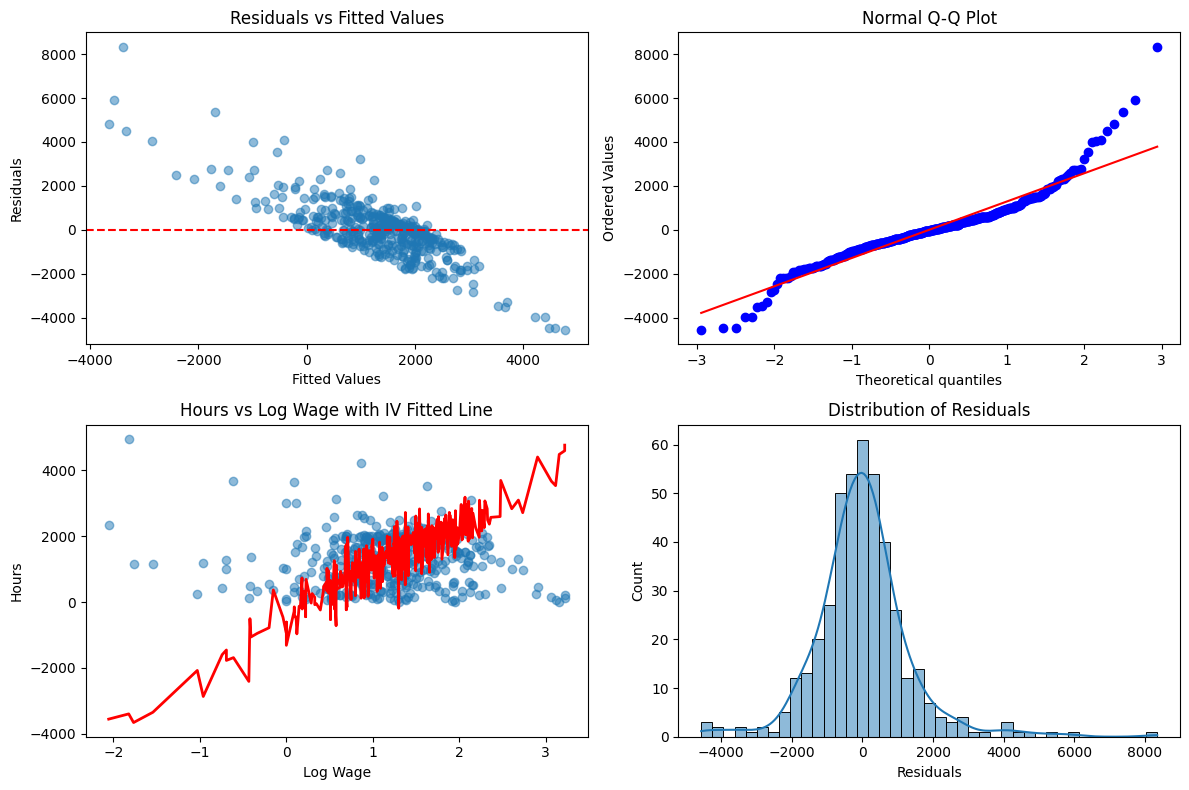

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [31]:
plt.figure(figsize=(12, 8))

# Residuals vs Fitted Values
plt.subplot(221)
plt.scatter(results.fitted_values, results.resids, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

# QQ Plot
plt.subplot(222)
stats.probplot(results.resids, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')

# Hours vs Wage scatter with fitted line
plt.subplot(223)
plt.scatter(mroz['log_wage'], mroz['hours'], alpha=0.5)
# Sort both x and corresponding y values together
x_sort = np.array(mroz['log_wage'])
y_sort = np.array(results.fitted_values)
sort_idx = np.argsort(x_sort)
x_sort = x_sort[sort_idx]
y_sort = y_sort[sort_idx]
plt.plot(x_sort, y_sort, color='r', linewidth=2)
plt.xlabel('Log Wage')
plt.ylabel('Hours')
plt.title('Hours vs Log Wage with IV Fitted Line')

# Distribution of residuals
plt.subplot(224)
sns.histplot(results.resids, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

# Additional diagnostic plots
plt.figure(figsize=(12, 4))

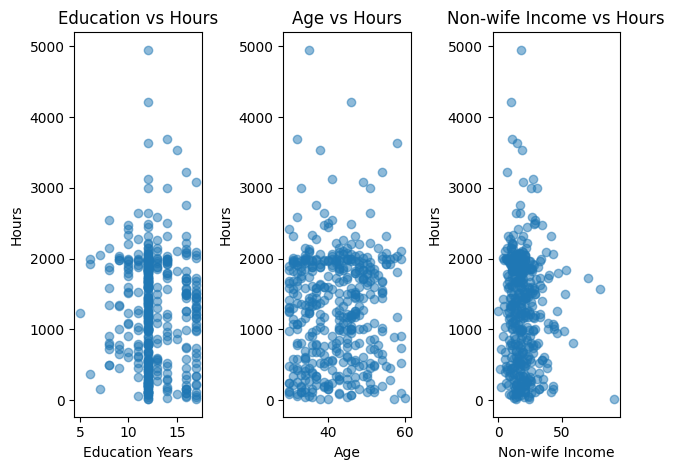

In [32]:
# Education vs Hours
plt.subplot(131)
plt.scatter(mroz['educ'], mroz['hours'], alpha=0.5)
plt.xlabel('Education Years')
plt.ylabel('Hours')
plt.title('Education vs Hours')

# Age vs Hours
plt.subplot(132)
plt.scatter(mroz['age'], mroz['hours'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Hours')
plt.title('Age vs Hours')

# Non-wife Income vs Hours
plt.subplot(133)
plt.scatter(mroz['nwifeinc'], mroz['hours'], alpha=0.5)
plt.xlabel('Non-wife Income')
plt.ylabel('Hours')
plt.title('Non-wife Income vs Hours')

plt.tight_layout()
plt.show()



In [33]:
# Summary statistics
print("\nCorrelation between Hours and Key Variables:")
correlations = mroz[['hours', 'log_wage', 'educ', 'age', 'nwifeinc']].corr()['hours']
print(correlations)


Correlation between Hours and Key Variables:
hours       1.000
log_wage   -0.016
educ       -0.066
age         0.051
nwifeinc   -0.082
Name: hours, dtype: float64


## Economic Analysis

In [35]:
# Wage elasticity by education level
print("\nWage Elasticity by Education Level:")
for level in sorted(mroz['educ'].unique()):
    subset = mroz[mroz['educ'] == level]
    if len(subset) > 0:
        mean_hours = subset['hours'].mean()
        elasticity = results.params['log_wage'] / mean_hours
        print(f"Education years {level}: {elasticity:.4f}")



Wage Elasticity by Education Level:
Education years 5: 1.3283
Education years 6: 1.1420
Education years 7: 1.4846
Education years 8: 1.2625
Education years 9: 1.2568
Education years 10: 0.9858
Education years 11: 1.3025
Education years 12: 1.2591
Education years 13: 1.2221
Education years 14: 1.1587
Education years 15: 1.0459
Education years 16: 1.3151
Education years 17: 1.4833


In [40]:
# Impact analysis
print("\nImpact Analysis:")
print(f"1. A $1 increase in non-wife income reduces hours worked by {abs(results.params['nwifeinc']):.2f} hours")
print(f"2. Having one more child under 6 reduces hours worked by {abs(results.params['kidslt6']):.2f} hours")
print(f"3. An additional year of education changes hours worked by {results.params['educ']:.2f} hours")


Impact Analysis:
1. A $1 increase in non-wife income reduces hours worked by 10.17 hours
2. Having one more child under 6 reduces hours worked by 206.99 hours
3. An additional year of education changes hours worked by -183.50 hours


In [41]:
# Test for weak instruments
all_exog = pd.concat([sm.add_constant(exog), instruments], axis=1)
first_stage = sm.OLS(endog, all_exog).fit()
f_stat = first_stage.fvalue
print(f"\nFirst-stage F-statistic: {f_stat:.2f}")
print("Rule of thumb: F > 10 indicates strong instruments")


First-stage F-statistic: 13.71
Rule of thumb: F > 10 indicates strong instruments


In [46]:
# Additional summary statistics
print("\nSummary of Key Variables:")
print(mroz[['hours', 'wage', 'educ', 'age', 'kidslt6']].describe())


Summary of Key Variables:
         hours    wage    educ     age  kidslt6
count  427.000 427.000 427.000 427.000  427.000
mean  1304.834   4.178  12.660  42.000    0.141
std    776.184   3.314   2.288   7.708    0.392
min     12.000   0.128   5.000  30.000    0.000
25%    620.000   2.258  12.000  35.000    0.000
50%   1376.000   3.472  12.000  42.000    0.000
75%   1911.000   4.973  14.000  47.500    0.000
max   4950.000  25.000  17.000  60.000    2.000


In [45]:
# Correlation matrix of key variables
print("\nCorrelation Matrix:")
corr_matrix = mroz[['hours', 'log_wage', 'educ', 'age', 'kidslt6', 'nwifeinc']].corr()
print(corr_matrix.round(3))


Correlation Matrix:
          hours  log_wage   educ    age  kidslt6  nwifeinc
hours     1.000    -0.016 -0.066  0.051   -0.169    -0.082
log_wage -0.016     1.000  0.344  0.056   -0.018     0.142
educ     -0.066     0.344  1.000 -0.053    0.129     0.284
age       0.051     0.056 -0.053  1.000   -0.341     0.096
kidslt6  -0.169    -0.018  0.129 -0.341    1.000    -0.028
nwifeinc -0.082     0.142  0.284  0.096   -0.028     1.000
